In [1]:
import os
import io
import gpxpy
import folium
import selenium
import requests
import numpy as np
import pandas as pd
import sqlite3 as sq
import seaborn as sb
import osmnx as ox
import matplotlib.pyplot as plt


from PIL import Image
from scipy.stats import normaltest, shapiro, kstest, f_oneway
from geopy.distance import geodesic
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
def parse_gpx(gpx_string, track_id):
    try:
        gpx = gpxpy.parse(gpx_string)
    except Exception as e:
        print(e)
        return None
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                points.append({
                            'track_id': track_id,
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time,
                            'name': track.name
                        })
    return points

In [3]:
def length(parsed_gpx):
    length_3d = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            p1 = (track['latitude'][idx], track['longitude'][idx])
            p2 = (track['latitude'][idx + 1], track['longitude'][idx + 1])
            length_2d = geodesic(p1, p2).meters
            if pd.notna(track['elevation'][idx]):
                length_track = np.sqrt((length_2d ** 2) + (track['elevation'][idx] - track['elevation'][idx + 1]) ** 2)
            else:
                length_track = length_2d
            length_3d.append(length_track)
        length_3d.append(None)
    return length_3d

In [4]:
def time_delta(parsed_gpx):
    time_delta = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1].sort_values('time')
        for idx in track.index[:-1]:
            time_delta.append(track['time'][idx + 1] - track['time'][idx])
        time_delta.append(None)
    return time_delta

In [5]:
def mean_day_temp(lat, lon, time):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
    	"latitude": lat,
    	"longitude": lon,
    	"start_date": time,
    	"end_date": time,
    	"daily": "temperature_2m_mean",
    }
    response = requests.get(url, params=params)
    return response.json()['daily']['temperature_2m_mean']

In [6]:
def temp_per_track(parsed_gpx):
    temp = []
    for track in parsed_gpx.groupby('track_id'):
        track = track[1]
        if pd.notna(track['time']).sum():
            id = track.index[0]
            test = mean_day_temp(track['latitude'][id], track['longitude'][id], str(track['time'][id])[:10])
            temp.append(test[0])
        else:
            temp.append(None)
    return temp

In [7]:
def parse_features(lat, lon, radius=500):
    point = (lat, lon)
    tags = {
        "water": {"natural": "water"},
        "forest": {"natural": "wood"},
        "buildings": {"building": True}
    }
    
    features = {}
    for key, tag in tags.items():
        try:
            gdf = ox.features.features_from_point(point, dist=radius, tags=tag)
            features[key] = len(gdf)
        except Exception as e:
            features[key] = 0
    
    return features

In [8]:
def get_features(parsed_gpx, n=3):
    water = []
    forest = []
    buildings = []
    features = parse_features(parsed_gpx['latitude'][0], parsed_gpx['longitude'][0])
    for idx in parsed_gpx.index:
        if idx % n == 0:
            features = parse_features(parsed_gpx['latitude'][idx], parsed_gpx['longitude'][idx])
        water.append(features['water'])
        forest.append(features['forest'])
        buildings.append(features['buildings'])
        print(f"Прочситано: {idx}/{len(parsed_gpx)}", end='\r')
        if idx == 40:
            break
    return water, forest, buildings

In [9]:
def around_type(df):
    if pd.notna(df[['water', 'forest', 'buildings']]).sum() and df[['water', 'forest', 'buildings' ]].sum():
        if df['water'] + df['forest'] > 0:
            around = {'water': df['water'], 'forest': df['forest']}
            return max(around, key=around.get)
        if df['buildings'] > 0:
            return 'city'
    return None

In [10]:
class Agent:
    def __init__(self, path_to_db:str, path_to_maps:str):
        self.path_to_db = path_to_db
        self.path_to_maps = path_to_maps
        ox.settings.use_cache=True

    def save_data(self):
        try:
            conn = sq.connect(self.path_to_db)
            self.data.to_sql("data", con=conn, if_exists="replace", index=False)
            conn.close()
        except Exception as e:
            print(e)

    def parse_paths(self, paths):
        all_points = []
        trace_id = []
        self.idx = 0
        for path in paths:
            gpx = open(path, 'r')
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"Создан dataframe с {len(parsed_gpx['track_id'].unique())} маршрутами")
        self.data = parsed_gpx

    def add_gpx(self, gpx_strings:list[str]):
        all_points = []
        for gpx in gpx_strings:
            parsed_gpx = parse_gpx(gpx, self.idx)
            if parsed_gpx:
                all_points.extend(parsed_gpx)
                self.idx += 1
        parsed_gpx = pd.DataFrame(all_points)
        print(f"В датасет добавлены {len(parsed_gpx['track_id'].unique())} маршрутов")
        self.data = pd.concat([self.data, parsed_gpx], ignore_index=True)

    def fill_dataset(self):
        parsed_gpx = self.data
        
        length_3d = length(parsed_gpx)
        parsed_gpx['length_3d'] = length_3d
        print("Посчитанны расстояния между точками")
    
        parsed_gpx['time_delta'] = time_delta(parsed_gpx)
        print("Просчитано время между точками")
    
        parsed_gpx['step_frequency'] = parsed_gpx.apply(lambda parsed_gpx: (parsed_gpx['length_3d'] / 0.75) / parsed_gpx['time_delta'].total_seconds(), axis=1)
        print("Просчитана частота шагов")
    
        temp = temp_per_track(parsed_gpx)
        parsed_gpx['tempurture'] = parsed_gpx['track_id'].map(lambda x: temp[x])
        print("Просчитана температура для каждого трека")

        n=10
        water, forest, buildings = get_features(parsed_gpx, n=n)
        parsed_gpx['water'] = water + [None] * (len(parsed_gpx) - len(water))
        parsed_gpx['forest'] = forest + [None] * (len(parsed_gpx) - len(forest))
        parsed_gpx['buildings'] = buildings + [None] * (len(parsed_gpx) - len(buildings))
        parsed_gpx['type'] = parsed_gpx.apply(around_type, axis=1)
        print(f'Посчитано количество обьектов вокруг каждой {n} точки')
        
        self.data = parsed_gpx

    def gen_img(self):
        for track in self.data.groupby('track_id'):
            track = track[1]
            idx = track['track_id'].mean()
            m = folium.Map(location=[track['latitude'].mean(), track['longitude'].mean()], zoom_start=12)
            folium.PolyLine(track[['latitude', 'longitude']].values).add_to(m)
            print(f"Карта маршрута {idx}")
            display(m)
            img_data = m._to_png(5)
            img = Image.open(io.BytesIO(img_data))
            img.save(os.path.join(self.path_to_maps, f'{idx}.png'))
        

# Создаём агента и указываем ему пути для сохранения данных

In [11]:
agent = Agent("data.db", "Maps/")
agent.parse_paths(['datasets/1.gpx', 'datasets/2.gpx', 'datasets/3.gpx', 'datasets/4.gpx'])

Создан dataframe с 4 маршрутами


In [12]:
gpx_data = pd.read_csv("datasets/gpx-tracks-from-hikr.org.csv")

In [13]:
agent.add_gpx(list(gpx_data['gpx'][:1]))

В датасет добавлены 1 маршрутов


In [14]:
agent.data

,track_id,latitude,longitude,elevation,time,name
0,0,46.988087,6.792303,1128.86,NaT,La Tourne - Vue des Alp - Genevey
1,0,46.988047,6.792166,1129.30,NaT,La Tourne - Vue des Alp - Genevey
2,0,46.989413,6.790911,1150.25,NaT,La Tourne - Vue des Alp - Genevey
3,0,46.990017,6.791000,1159.11,NaT,La Tourne - Vue des Alp - Genevey
4,0,46.990729,6.791723,1170.55,NaT,La Tourne - Vue des Alp - Genevey
...,...,...,...,...,...,...
832,4,47.230664,13.225396,1360.05,2018-05-11 11:34:28+00:00,remsteinkopf
833,4,47.230889,13.225442,1354.79,2018-05-11 11:34:46+00:00,remsteinkopf
834,4,47.230412,13.227277,1339.36,2018-05-11 11:36:43+00:00,remsteinkopf
835,4,47.230534,13.227554,1331.91,2018-05-11 11:36:59+00:00,remsteinkopf


# Дополняем датасет необходимыми признаками

In [15]:
agent.fill_dataset()

Посчитанны расстояния между точками
Просчитано время между точками
Просчитана частота шагов
Просчитана температура для каждого трека
Посчитано количество обьектов вокруг каждой 10 точки


# Создаём карты с наложеными маршрутами

In [16]:
agent.gen_img()

Карта маршрута 0.0


Карта маршрута 1.0


Карта маршрута 2.0


Карта маршрута 3.0


Карта маршрута 4.0


In [17]:
agent.save_data()

C:\Users\demoexam\AppData\Local\Temp\ipykernel_3996\3253151044.py:10: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  self.data.to_sql("data", con=conn, if_exists="replace", index=False)


In [18]:
agent.data.isnull().sum()

track_id            0
latitude            0
longitude           0
elevation           0
time              132
name                0
length_3d           5
time_delta        136
step_frequency    136
tempurture        132
water             796
forest            796
buildings         796
type              796
dtype: int64

In [43]:
agent.data

,track_id,latitude,longitude,elevation,time,name,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings,type
0,0,46.988087,6.792303,1128.86,NaT,La Tourne - Vue des Alp - Genevey,11.339566,NaT,NaN,NaN,0.0,1.0,17.0,forest
1,0,46.988047,6.792166,1129.30,NaT,La Tourne - Vue des Alp - Genevey,180.595312,NaT,NaN,NaN,0.0,1.0,17.0,forest
2,0,46.989413,6.790911,1150.25,NaT,La Tourne - Vue des Alp - Genevey,68.066622,NaT,NaN,NaN,0.0,1.0,17.0,forest
3,0,46.990017,6.791000,1159.11,NaT,La Tourne - Vue des Alp - Genevey,97.061687,NaT,NaN,NaN,0.0,1.0,17.0,forest
4,0,46.990729,6.791723,1170.55,NaT,La Tourne - Vue des Alp - Genevey,29.946428,NaT,NaN,NaN,0.0,1.0,17.0,forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,4,47.230664,13.225396,1360.05,2018-05-11 11:34:28+00:00,remsteinkopf,25.797772,0 days 00:00:18,1.910946,10.4,NaN,NaN,NaN,None
833,4,47.230889,13.225442,1354.79,2018-05-11 11:34:46+00:00,remsteinkopf,149.534270,0 days 00:01:57,1.704094,10.4,NaN,NaN,NaN,None
834,4,47.230412,13.227277,1339.36,2018-05-11 11:36:43+00:00,remsteinkopf,26.067067,0 days 00:00:16,2.172256,10.4,NaN,NaN,NaN,None
835,4,47.230534,13.227554,1331.91,2018-05-11 11:36:59+00:00,remsteinkopf,74.542733,0 days 00:01:24,1.183218,10.4,NaN,NaN,NaN,None


# Описания признаков получившегося датасета

In [20]:
describtions = pd.read_csv("describtions.csv")
describtions

,Название,Перевод,Описание,Тип данных,Система счисления,Unnamed: 5
0,latitude,высота,GPS высота точки,float,Градусы,NaN
1,longitude,широта,GPS широта точки,float,Градусы,NaN
2,elevation,высота над уровнем моря,высота точки над уровнем моря,float,метры,NaN
3,time,время,время регистрации точки,TimeDate,-,NaN
4,name,имя,имя маршрута,str,-,NaN
5,length_3d,длина трёхмерная,расстояние между точками с учётом высоты,float,метры,NaN
6,time_delta,разница времени,время прохождения между двумя точками,TimeDelta,-,NaN
7,step_frequency,частота шагов,частота шагов,float,Гц,NaN
8,tempurture,температура,температура воздуха на момент прохождения,float,Градусы,NaN
9,water,вода,кол-во водоёмов,int,-,NaN


# Статистика

## length_3d

<Axes: xlabel='length_3d', ylabel='Count'>

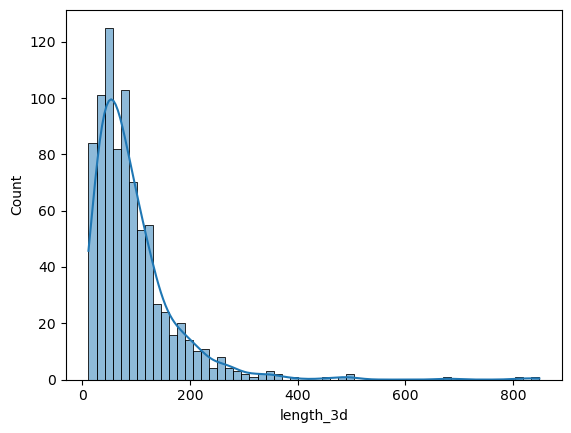

In [21]:
sb.histplot(agent.data['length_3d'], kde=True)

In [22]:
res = normaltest(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [23]:
res = shapiro(agent.data['length_3d'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [24]:
res = kstest(agent.data['length_3d'], 'expon')
print(res.statistic)
print(res.pvalue)

nan
nan


## time_delta

<Axes: xlabel='time_delta', ylabel='Count'>

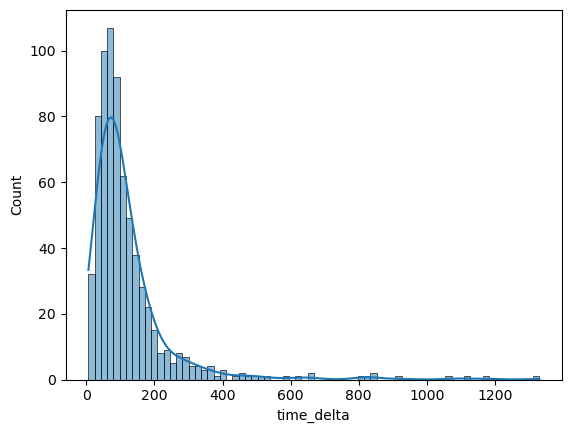

In [25]:
sb.histplot(agent.data['time_delta'].map(lambda x: x.seconds), kde=True)

In [26]:
res = normaltest(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

nan
nan


In [27]:
res = shapiro(agent.data['time_delta'].map(lambda x: x.seconds))
print(res.statistic)
print(res.pvalue)

nan
nan


In [28]:
res = kstest(agent.data['time_delta'].map(lambda x: x.seconds), "expon")
print(res.statistic)
print(res.pvalue)

nan
nan


## tempurture

<Axes: xlabel='tempurture', ylabel='Count'>

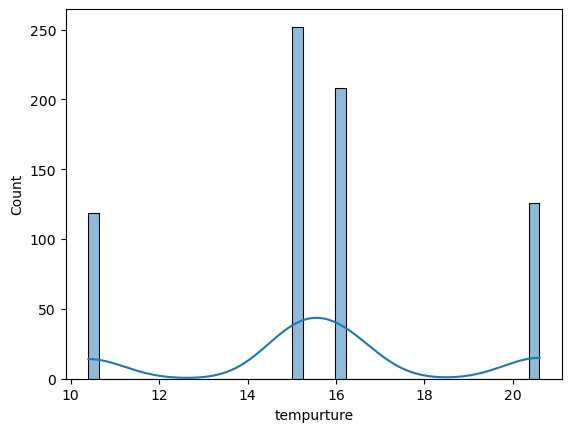

In [29]:
sb.histplot(agent.data['tempurture'], kde=True)

In [30]:
res = normaltest(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [31]:
res = shapiro(agent.data['tempurture'])
print(res.statistic)
print(res.pvalue)

nan
nan


## step_frequency

<Axes: xlabel='step_frequency', ylabel='Count'>

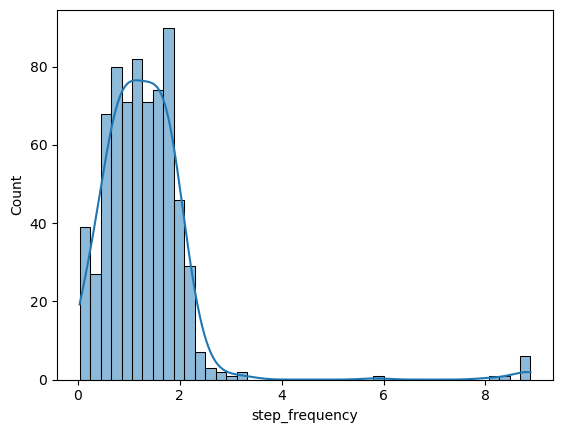

In [32]:
sb.histplot(agent.data['step_frequency'], kde=True)

In [33]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [34]:
res = normaltest(agent.data['step_frequency'])
print(res.statistic)
print(res.pvalue)

nan
nan


In [35]:
res = kstest(agent.data['step_frequency'], "expon")
print(res.statistic)
print(res.pvalue)

nan
nan


## type

<Axes: xlabel='type', ylabel='Count'>

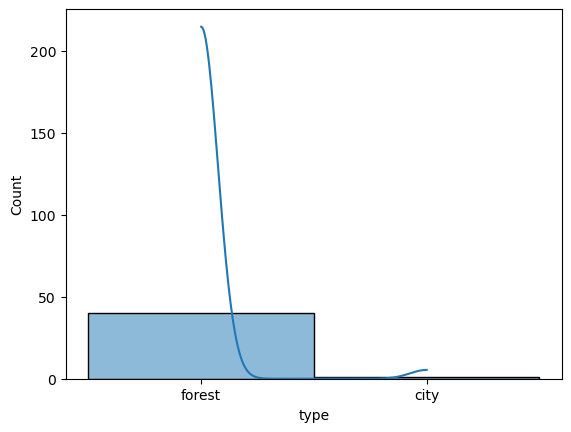

In [36]:
sb.histplot(agent.data['type'], kde=True)

Создание числового датасета

In [37]:
clean = agent.data.dropna()
clean = clean.drop(['name'], axis=1)
clean["type"] = clean["type"].map({'city': 0, 'water': 1, 'forest': 2})
clean['time_delta'] = clean['time_delta'].map(lambda x: x.seconds)
clean['time'] = clean['time'].map(lambda x: x.timestamp())

In [38]:
clean

,track_id,latitude,longitude,elevation,time,length_3d,time_delta,step_frequency,tempurture,water,forest,buildings,type


In [39]:
res = normaltest(clean['type'])
print(res.statistic)
print(res.pvalue)

nan
nan


C:\Users\demoexam\AppData\Local\Temp\ipykernel_3996\3857008483.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = normaltest(clean['type'])


In [40]:
res = shapiro(clean['type'])
print(res.statistic)
print(res.pvalue)

nan
nan


C:\Users\demoexam\AppData\Local\Temp\ipykernel_3996\2452860584.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = shapiro(clean['type'])


# Анализ значимых атрибутов

C:\Users\demoexam\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\demoexam\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


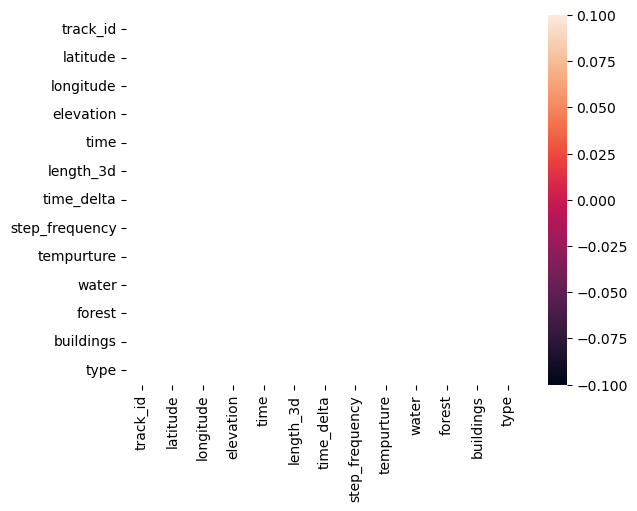

In [41]:
cor = clean.corr()
sb.heatmap(cor)
plt.show()

In [42]:
groups = [group['type'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

TypeError: At least two samples are required; got 0.

In [ ]:
groups = [group['latitude'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['longitude'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['time'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['length_3d'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['elevation'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

In [ ]:
groups = [group['forest'].values for name, group in clean.groupby('track_id')]
f_stat, p_val = f_oneway(*groups)
print(f_stat, p_val)

### Анализ атрибутов показал, что признаки ('type', 'latitude', 'longitude', 'time', 'length_3d', 'elevation', 'forest') в датасете сильно влияют на схожесть групп

## Проводим кластеризацию используя значимые атрибуты

In [ ]:
pca = PCA(n_components=2)
class_data = clean[['type', 'latitude', 'longitude', 'time', 'length_3d', 'elevation', 'forest']]
data_2d = pca.fit_transform(class_data)
dbscan = KMeans(n_clusters=3)
dbscan.fit(data_2d)
labels = dbscan.fit_predict(class_data)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Добавляем получившееся каластеры в датасет и сохраняем в БД

In [ ]:
labels = pd.Series(labels)
labels.name = "cluster"
clean = pd.concat([clean, labels], axis=1)

In [ ]:
try:
    conn = sq.connect("data.db")
    clean.to_sql("clean", con=conn, if_exists="replace", index=False)
    conn.close()
except Exception as e:
    print(e)